In [1]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
    
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)

tensor([1.], device='cuda:0')


In [3]:
# Must define the class of the model which was used to train the model to load weights into
class VGG16(nn.Module):
	def __init__(self):
		super().__init__()
		
		# First convolution block. 2 3x3 convs followed by a 2x2 
		self.conv1 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=3,
			out_channels=64,
		)
		self.relu1 = nn.ReLU()
		self.conv2 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=64,
			out_channels=64,
		)
		self.relu2 = nn.ReLU()	
		self.maxpool1 = nn.MaxPool2d(
			kernel_size=(2,2),
			stride=2,
		)
		
		# Second convolution block same as above, difference is in number of channels outputted (128 here)
		self.conv3 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=64,
			out_channels=128,
		)
		self.relu3 = nn.ReLU()
		self.conv4 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=128,
			out_channels=128,
		)
		self.relu4 = nn.ReLU()
		self.maxpool2 = nn.MaxPool2d(
			kernel_size=(2, 2),
			stride=2,
		)
		
		# Third convolution block, this one has 3 convolutions before MP layer and more channels outputted (256)
		self.conv5 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=128,
			out_channels=256,
		)
		self.relu5 = nn.ReLU()
		self.conv6 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=256,
			out_channels=256,
		)
		self.relu6 = nn.ReLU()
		self.conv7 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=256,
			out_channels=256,
		)
		self.relu7 = nn.ReLU()
		self.maxpool3 = nn.MaxPool2d(
			kernel_size=(2, 2),
			stride=2,
		)
		
		# Fourth convolution block, same as third (3 convolutional layers) but more channels outputted (512)
		self.conv8 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=256,
			out_channels=512,
		)
		self.relu8 = nn.ReLU()
		self.conv9 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=512,
			out_channels=512,
		)
		self.relu9 = nn.ReLU()
		self.conv10 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=512,
			out_channels=512,
		)
		self.relu10 = nn.ReLU()
		self.maxpool4 = nn.MaxPool2d(
			kernel_size=(2, 2),
			stride=2,
		)
		
		# Fifth and final convolutional block, exactly the same as the fourth
		self.conv11 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=512,
			out_channels=512,
		)
		self.relu11 = nn.ReLU()
		self.conv12 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=512,
			out_channels=512,
		)
		self.relu12 = nn.ReLU()
		self.conv13 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=512,
			out_channels=512,
		)
		self.relu13 = nn.ReLU()
		self.maxpool5 = nn.MaxPool2d(
			kernel_size=(2, 2),
			stride=2,
		)
		
		# Fully connected layers, first two have dropout of p=0.5
		self.fc1 = nn.Linear(
			in_features=25088,
			out_features=4096,
		)
		self.relu14 = nn.ReLU()
		self.dropout1 = nn.Dropout(p=0.5)
		
		# Second fully connected layer
		self.fc2 = nn.Linear(in_features=4096,
		                     out_features=4096,
		)
		self.relu15 = nn.ReLU()
		self.dropout2 = nn.Dropout(p=0.5)
		
		# Final output linear layer (will create 2, one for ImageNet and one for Cifar10)
		#self.fc3 = nn.Linear(
		#	in_features=4096,
		#	out_features=1000,
		#)
		self.fc3 = nn.Linear(
			in_features=4096,
			out_features=10,
		)
	
	def forward(self, x):
		# First conv block
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool1(x)
		#print(f'Shape after 1st block: {x.shape}')
		
		# Second conv block
		x = self.conv3(x)
		x = self.relu3(x)
		x = self.conv4(x)
		x = self.relu4(x)
		x = self.maxpool2(x)
		#print(f'Shape after 2nd block: {x.shape}')
		
		# Third conv block
		x = self.conv5(x)
		x = self.relu5(x)
		x = self.conv6(x)
		x = self.relu6(x)
		x = self.conv7(x)
		x = self.relu7(x)
		x = self.maxpool3(x)
		#print(f'Shape after 3rd block: {x.shape}')
		      
		# Fourth conv block
		x = self.conv8(x)
		x = self.relu8(x)
		x = self.conv9(x)
		x = self.relu9(x)
		x = self.conv10(x)
		x = self.relu10(x)
		x = self.maxpool4(x)
		#print(f'Shape after 3rd block: {x.shape}')
		
		# Fifth conv block
		x = self.conv11(x)
		x = self.relu11(x)
		x = self.conv12(x)
		x = self.relu12(x)
		x = self.conv13(x)
		x = self.relu13(x)
		x = self.maxpool5(x)
		#print(f'Shape after 3rd block: {x.shape}')
		
		# Must flatten output of convolutions for input the linear layers
		x = torch.flatten(x, start_dim=0)
		#print(f'Shape after flattening: {x.shape}')
		
		x = self.fc1(x)
		x = self.relu14(x)
		x = self.dropout1(x)
		#print(f'Shape after 1st FC: {x.shape}')
		
		x = self.fc2(x)
		x = self.relu15(x)
		x = self.dropout2(x)
		#print(f'Shape after 2nd FC: {x.shape}')
		
		x = self.fc3(x)
		#print(f'Shape after 3rd FC: {x.shape}')
		
		return x
	
# Init model weights by VGG scheme
def vgg_weight_init(net):
    """
    Initializes weights as per the VGG scheme.
    """
    if isinstance(net, nn.Conv2d):
        nn.init.normal_(net.weight, mean=0.0, std=0.01)
        if net.bias is not None:
            nn.init.constant_(net.bias, 0)
    elif isinstance(net, nn.Linear):
        nn.init.normal_(net.weight, mean=0.0, std=0.01)
        nn.init.constant_(net.bias, 0)
    # You can add initialization for other types of layers if needed

def glorot_uniform_init(net):
    if isinstance(net, nn.Linear) or isinstance(net, nn.Conv2d):
        nn.init.xavier_uniform_(net.weight)
        if net.bias is not None:
            nn.init.constant_(net.bias, 0)

model = VGG16()
model = torch.load('/home/yusuf/python/EyesOff/paper_implementations/VGG16_Cifar10.pth')
model.to(device)
model.eval()

VGG16(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu6): ReLU()
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu7): ReLU()
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv8): Conv2d(256, 512, kernel_siz

Cifar 10 class labels:
0 - airplane
1 - automobile
2 - bird
3 - cat 
4 - deer
5 - dog
6 - frog
7 - horse
8 - ship
9 - truck

In [4]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.48227 ,0.4465], std=[0.2470, 0.2435, 0.2616]), #Normalize using mean and std dev of cifar10
])

train_dataset = CIFAR10(root='./CIFAR', train=True, download=False, transform=transform)
test_dataset = CIFAR10(root='./CIFAR', train=False, download=False, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


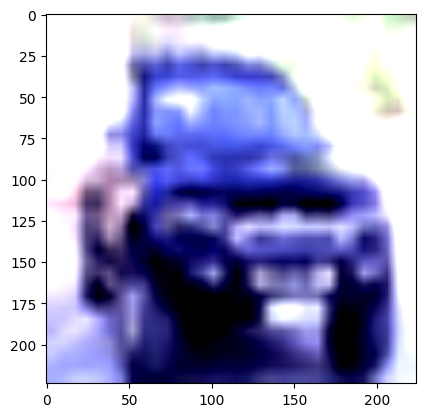

1

In [15]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

imshow(test_dataset[9][0])
test_dataset[9][1]

In [16]:
img, label = test_dataset[9]
label = torch.Tensor([label])
img, label = img.to(device), label.to(device)

pred = model(img)

In [17]:
pred.argmax() == label

tensor([True], device='cuda:0')

In [18]:
# Extract all convolutional layers from the network and their respective weights

conv_layers = []
model_weights = []

for child in model.children():
    if isinstance(child, nn.Conv2d):
        conv_layers.append(child)
        model_weights.append(child.weight)
        
conv_layers

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

In [19]:
outputs = []
names = []
for layer in conv_layers:
    img = layer(img)
    outputs.append(img)
    names.append(str(layer))

#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

torch.Size([64, 224, 224])
torch.Size([64, 224, 224])
torch.Size([128, 224, 224])
torch.Size([128, 224, 224])
torch.Size([256, 224, 224])
torch.Size([256, 224, 224])
torch.Size([256, 224, 224])
torch.Size([512, 224, 224])
torch.Size([512, 224, 224])
torch.Size([512, 224, 224])
torch.Size([512, 224, 224])
torch.Size([512, 224, 224])
torch.Size([512, 224, 224])


In [20]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


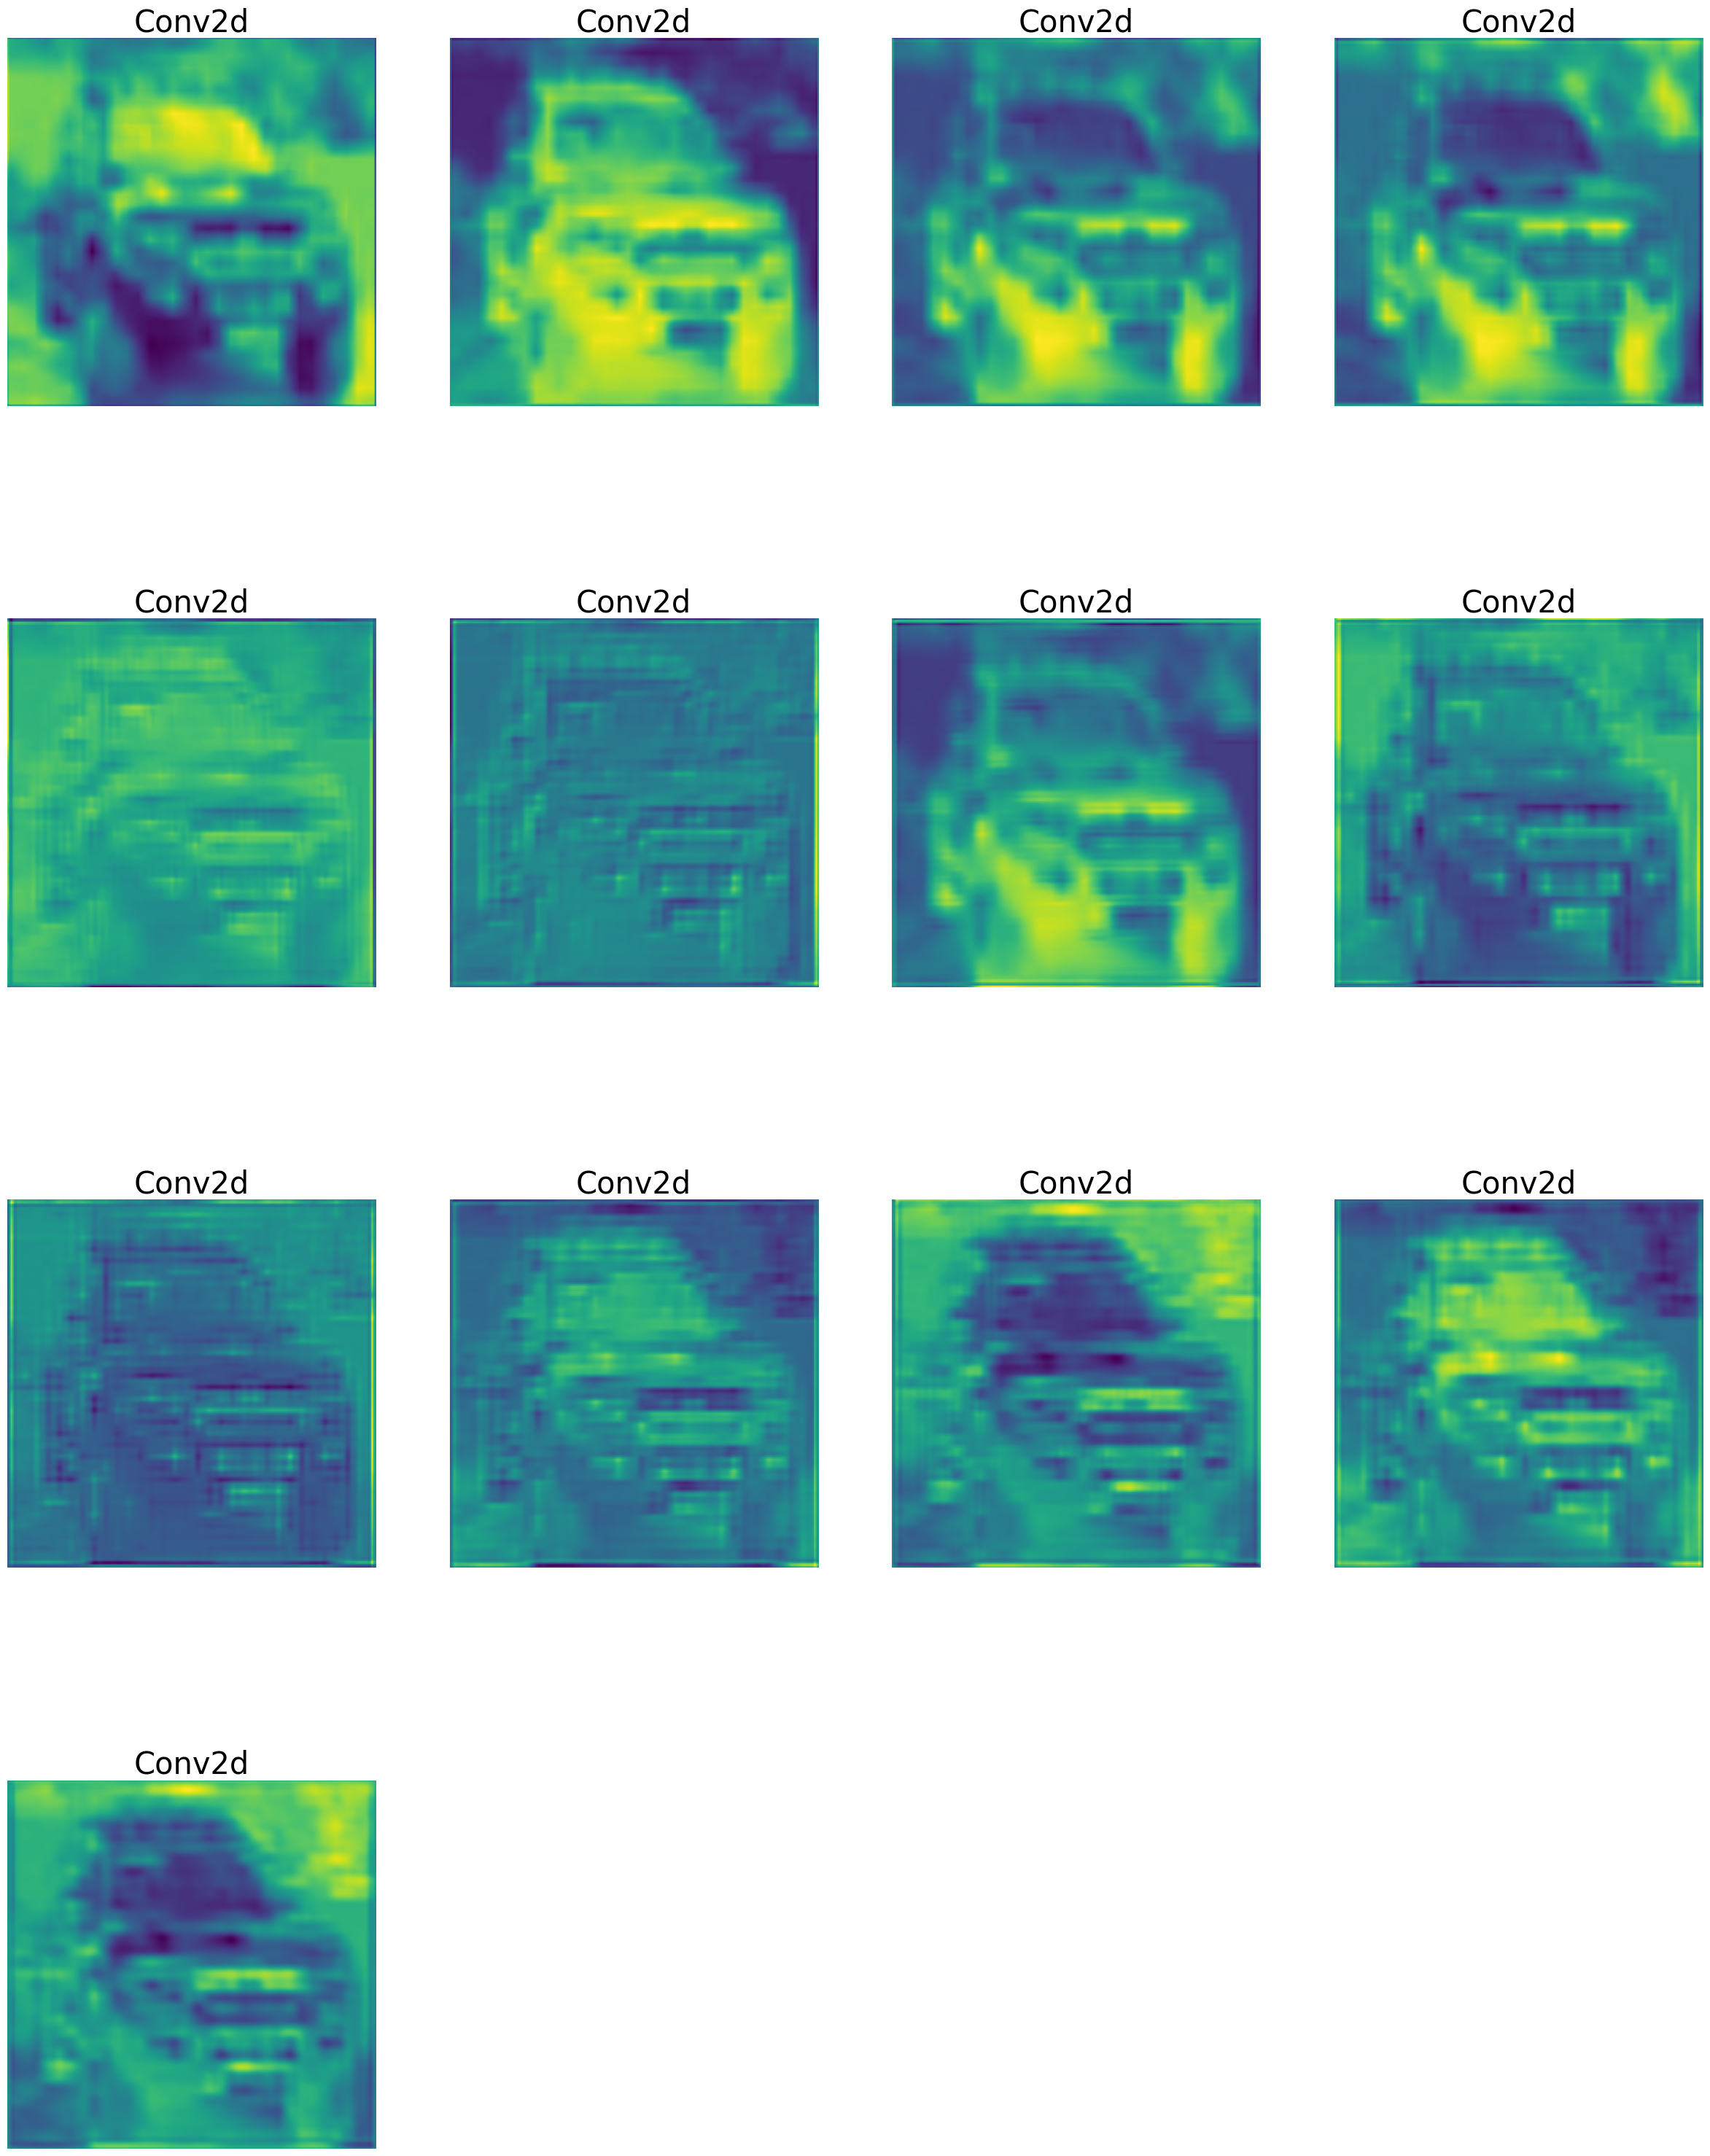

In [21]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
#plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')